In [1]:
import tensorflow as tf
import keras 
from keras import models, layers, regularizers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE_1 = 256
IMAGE_SIZE_2 = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
# Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset',
    shuffle=True,
    image_size=(IMAGE_SIZE_1, IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
n_classes = len(class_names)
print(f"Number of classes: {n_classes}")

Found 4662 files belonging to 12 classes.
Number of classes: 12


In [4]:
# Dataset Partitioning
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"Training batches: {len(train_ds)}, Validation batches: {len(val_ds)}, Test batches: {len(test_ds)}")

# Optimize Dataset Performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Training batches: 116, Validation batches: 14, Test batches: 16


In [5]:
# Preprocessing (Rescaling)
preprocess_input = layers.Rescaling(1./255)

# Base Model Setup (MobileNetV2)
IMG_SHAPE = (IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

C:\Users\Sachintha Madushan\AppData\Local\Temp\ipykernel_16712\1217284432.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [6]:
# Freeze the base model
base_model.trainable = False

In [7]:
# Build the Full Model with Transfer Learning

inputs = tf.keras.Input(shape=IMG_SHAPE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")
x = data_augmentation(inputs)

# Rescale/Preprocess
x = preprocess_input(x)

# Base MobileNetV2 for feature extraction
x = base_model(x, training=False) 

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.3)(x)

outputs = layers.Dense(n_classes, activation='softmax')(x)

bananaLeafModel_TL = tf.keras.Model(inputs, outputs)

bananaLeafModel_TL.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │          15,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Compile the Model
bananaLeafModel_TL.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,          
    mode='min',
    restore_best_weights=True 
)

In [10]:
# Initial Training
history_fe = bananaLeafModel_TL.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.2701 - loss: 2.2512 - val_accuracy: 0.6719 - val_loss: 1.3579
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6702 - loss: 1.1826 - val_accuracy: 0.7879 - val_loss: 0.8437
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7709 - loss: 0.8619 - val_accuracy: 0.8393 - val_loss: 0.6439
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8101 - loss: 0.6975 - val_accuracy: 0.8504 - val_loss: 0.5357
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8290 - loss: 0.6023 - val_accuracy: 0.8571 - val_loss: 0.4615
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8371 - loss: 0.5357 - val_accuracy: 0.8750 - val_loss: 0.4098
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8536 - loss: 0.4770 - val_accuracy: 0.8795 - val_loss: 0.3744
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8633 - loss: 0.4382 - val_accu

In [11]:
# Fine-Tuning Setup

base_model.trainable = True

# Freeze layers 
for layer in base_model.layers:
    if layer.name.startswith('block_15_expand'):
        break
    layer.trainable = False

In [12]:
bananaLeafModel_TL.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

In [13]:
initial_epochs = len(history_fe.epoch) 

fine_tune_for_epochs = 30 

fine_tune_epochs = initial_epochs + fine_tune_for_epochs

In [14]:
history_ft = bananaLeafModel_TL.fit(
    train_ds,
    epochs=fine_tune_epochs,     
    initial_epoch=initial_epochs, 
    validation_data=val_ds,
)

Epoch 51/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.8784 - loss: 0.3745 - val_accuracy: 0.9598 - val_loss: 0.1265
Epoch 52/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9265 - loss: 0.2370 - val_accuracy: 0.9531 - val_loss: 0.1182
Epoch 53/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9335 - loss: 0.2080 - val_accuracy: 0.9487 - val_loss: 0.1127
Epoch 54/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9430 - loss: 0.1853 - val_accuracy: 0.9621 - val_loss: 0.1002
Epoch 55/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9452 - loss: 0.1726 - val_accuracy: 0.9643 - val_loss: 0.0899
Epoch 56/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9481 - loss: 0.1609 - val_accuracy: 0.9621 - val_loss: 0.0920
Epoch 57/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.9557 - loss: 0.1454 - val_accuracy: 0.9688 - val_loss: 0.0844
Epoch 58/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9522 - loss: 0.1490 - 

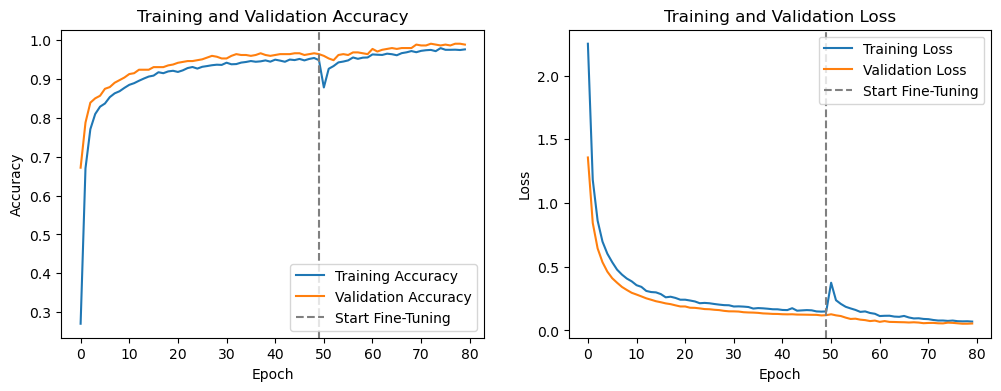

In [15]:
# Combine the history objects to plot the full training run
acc = history_fe.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_fe.history['val_accuracy'] + history_ft.history['val_accuracy']

train_loss = history_fe.history['loss'] + history_ft.history['loss']
val_loss = history_fe.history['val_loss'] + history_ft.history['val_loss']

# Get the total number of epochs run
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Add a vertical line to show where fine-tuning started
plt.axvline(x=initial_epochs - 1, color='grey', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss') 
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Add a vertical line to show where fine-tuning started
plt.axvline(x=initial_epochs - 1, color='grey', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig('training_history_full.png')
plt.show()

In [19]:
final_train_accuracy = history_ft.history['accuracy'][-1]
final_val_accuracy = history_ft.history['val_accuracy'][-1]
final_train_loss = history_ft.history['loss'][-1]
final_val_loss = history_ft.history['val_loss'][-1]

print("Final Training Metrics (from last epoch)")
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Metrics (from last epoch)
Final Training Accuracy: 97.65%
Final Validation Accuracy: 98.88%
Final Training Loss: 0.0693
Final Validation Loss: 0.0543


In [20]:
print("\nEvaluating on Test Set")
test_loss, test_accuracy = bananaLeafModel_TL.evaluate(test_ds)

print(f"\nTest Set Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Set Loss: {test_loss:.4f}")


Evaluating on Test Set
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9824 - loss: 0.0843

Test Set Accuracy: 98.24%
Test Set Loss: 0.0843


In [22]:
bananaLeafModel_TL.save('banana_disease_model_new.keras')

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

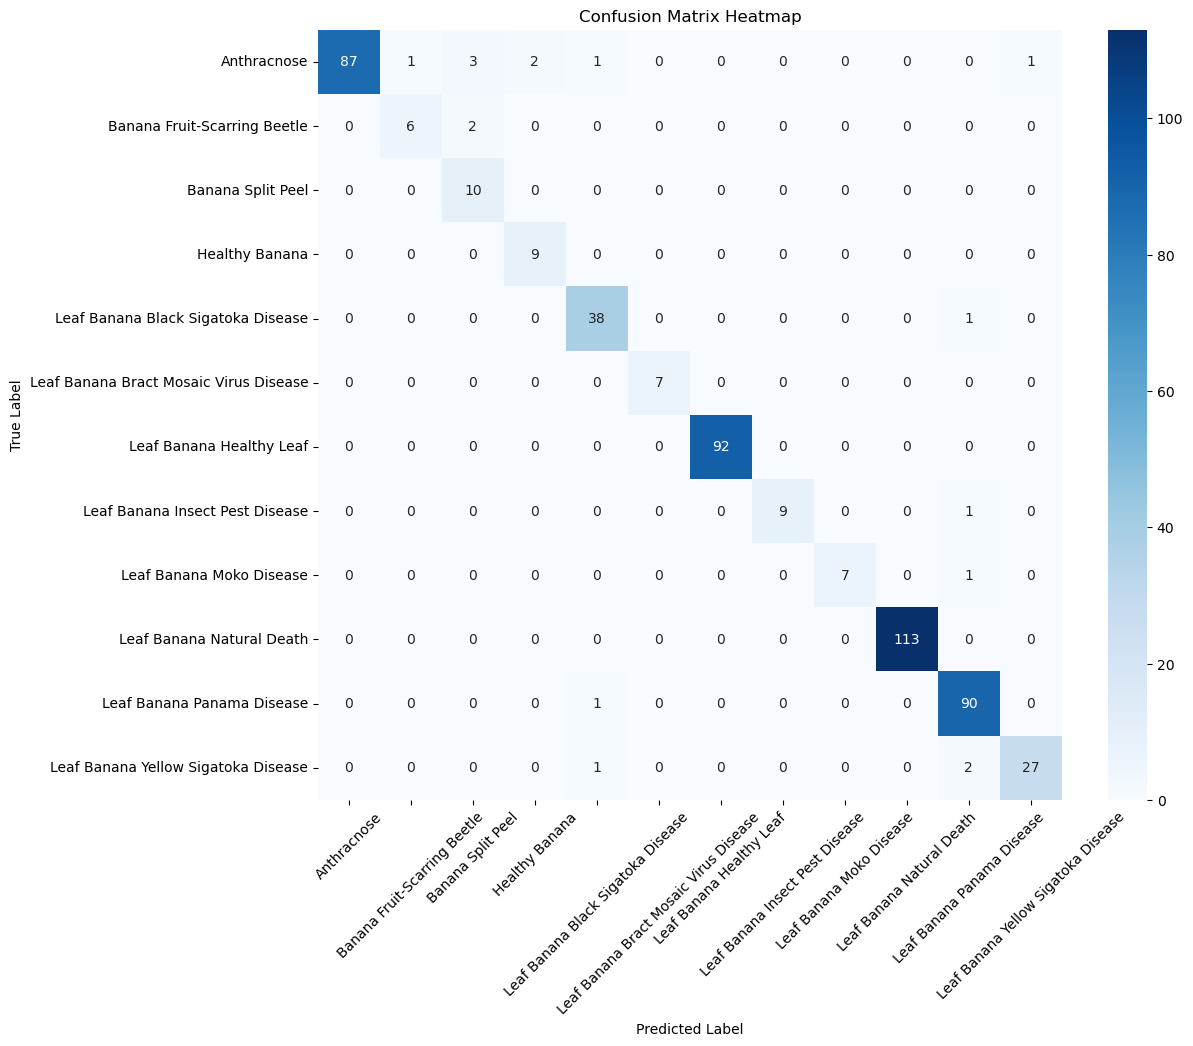

In [24]:
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    preds = bananaLeafModel_TL.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [25]:
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Classification Report:

                                        precision    recall  f1-score   support

                           Anthracnose       1.00      0.92      0.96        95
          Banana Fruit-Scarring Beetle       0.86      0.75      0.80         8
                     Banana Split Peel       0.67      1.00      0.80        10
                        Healthy Banana       0.82      1.00      0.90         9
    Leaf Banana Black Sigatoka Disease       0.93      0.97      0.95        39
Leaf Banana Bract Mosaic Virus Disease       1.00      1.00      1.00         7
              Leaf Banana Healthy Leaf       1.00      1.00      1.00        92
       Leaf Banana Insect Pest Disease       1.00      0.90      0.95        10
              Leaf Banana Moko Disease       1.00      0.88      0.93         8
             Leaf Banana Natural Death       1.00      1.00      1.00       113
            Leaf Banana Panama Disease       0.95      0.99      0.97        91
   Leaf Banana

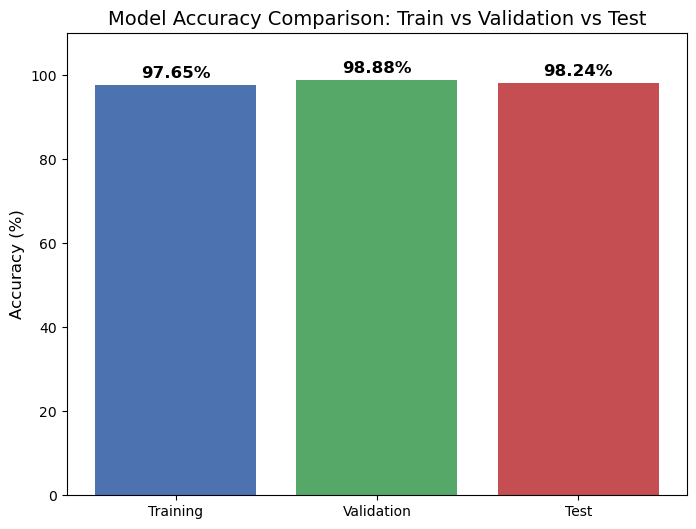

In [30]:
accuracies = {
    'Training': final_train_accuracy * 100,
    'Validation': final_val_accuracy * 100,
    'Test': test_accuracy * 100
}

labels = list(accuracies.keys())
values = list(accuracies.values())
colors = ['#4c72b0', '#55a868', '#c44e52']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

plt.ylim(0, 110)

plt.title('Model Accuracy Comparison: Train vs Validation vs Test', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()